In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [ ]:
train_data = torchvision.datasets.FashionMNIST('/content/Fashionmnist_train', train=True, download=True, transform=ToTensor())
test_data = torchvision.datasets.FashionMNIST('/content/Fashionmnist_test', train=False, download =True,transform=ToTensor() )


In [ ]:
np.unique(train_data.targets.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=32,
                                          shuffle=True,
                                          )
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=False,
                                          )
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e5750874970>,
 <torch.utils.data.dataloader.DataLoader at 0x7e5751194dc0>)

torch.Size([32, 1, 28, 28])
w =  28
h =  28
c =  1
Batch size =  32
label =  5


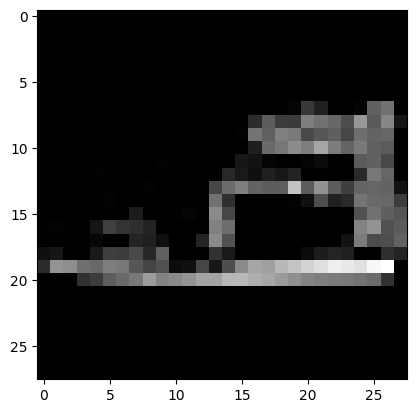

In [ ]:
for input , target in train_loader:
  print(input.shape)

  print('w = ',input[0].shape[1])
  print('h = ',input[0].shape[2])
  print('c = ',input[0].shape[0])
  print('Batch size = ',input.shape[0])

  plt.imshow(input[0].numpy().reshape(28,28),cmap="gray" )
  print('label = ', int(target[0]))
  break

# Build Model

In [ ]:
class Model(nn.Module):
  def __init__(self,K):
    super(Model,self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels = 1 , out_channels= 32 ,kernel_size =3 , stride = 2),
        # output = 13x13x32 (HxWxC)
        nn.ReLU(),
        nn.Conv2d(in_channels = 32 , out_channels= 64 ,kernel_size =3 , stride = 2),
        # output = 6x6x64 (HxWxC)
        nn.ReLU(),
        nn.Conv2d(in_channels = 64 , out_channels= 128 ,kernel_size =3 , stride = 2),
        # output =  2*2*128(HxWxC)
        nn.ReLU(),
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
        # no need to softmax
    )
  def forward(self,X):
    out = self.conv_layers(X)
    out = out.view(out.size(0),-1)
    out= self.dense_layers(out)
    return out



In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

model = Model(K=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

GPU is available and being used


In [ ]:
def train (model,optimizer,criterion,epochs,train_loader,test_loader):
  train_losses = []
  test_losses=[]
  for it in range(epochs):
    train_loss = []
    test_loss = []
    for inputs,targets in train_loader:
      inputs,targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs,targets)
      train_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    train_losses.append(np.mean(train_loss))

    for test_inputs,test_targets in test_loader:
      test_inputs,test_targets = test_inputs.to(device), test_targets.to(device)
      output_test = model(test_inputs)
      loss = criterion(output_test,test_targets)
      test_loss.append(loss.item())
    test_losses.append(np.mean(test_loss))

  return train_losses, test_losses


In [ ]:
train_loss, test_loss = train(model,optimizer,criterion,20,train_loader,test_loader)

In [ ]:
len(train_loss)

20

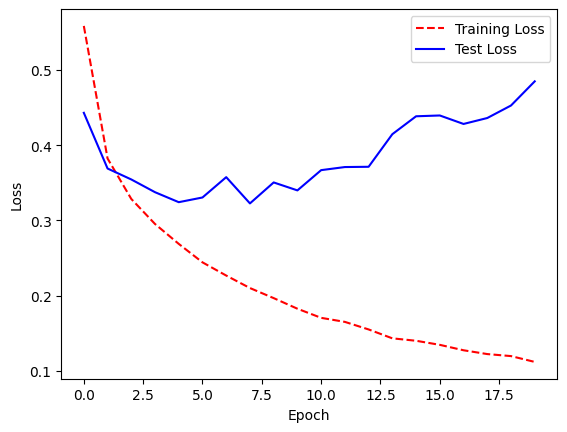

In [ ]:
# Visualize loss history
plt.plot(range(20), train_loss, 'r--')
plt.plot(range(20), test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


### Check test & train accuracy


In [ ]:
yhat = np.array([])
y = np.array([])
for test_inputs,test_targets in test_loader:
  test_inputs,test_targets = test_inputs.to(device), test_targets.to(device)
  output_test = model(test_inputs)
  yhat = np.append(yhat,output_test.cpu().detach().numpy().argmax(axis=1))
  y = np.append(y,test_targets.cpu().numpy())

print('Test acc', accuracy_score(y,yhat))


yhat = np.array([])
y = np.array([])
for train_inputs,train_targets in train_loader:
  train_inputs,train_targets = train_inputs.to(device), train_targets.to(device)
  output_train = model(train_inputs)
  yhat = np.append(yhat,output_train.cpu().detach().numpy().argmax(axis=1))
  y = np.append(y,train_targets.cpu().numpy())

print('Train acc', accuracy_score(y,yhat))


Test acc 0.8881
Train acc 0.9607
